 # HoVerNet - The CoNIC Baseline
 Code taken from: https://github.com/TissueImageAnalytics/CoNIC


Installing the tiatoolbox:

In [ ]:
!apt-get -y install libopenjp2-7-dev libopenjp2-tools openslide-tools | tail --line 1
!pip install git+https://github.com/TissueImageAnalytics/tiatoolbox.git@develop | tail --line 1

print("Installation is done.")

Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
  Running command git clone --filter=blob:none --quiet https://github.com/TissueImageAnalytics/tiatoolbox.git /tmp/pip-req-build-rgv9xj_u
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas~=1.5.3, but you have pandas 2.0.1 which is incompatible.
Installation is done.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
ON_GPU = True

 ## Importing Libraries and Workspace Settings
 We import some Python modules that are utilised throughout the notebook.

 > **Note**: We use `tiatoolbox` extensively in this repository.
 > You can refer to [here](https://github.com/TissueImageAnalytics/tiatoolbox) for installation instructions.
 > For this notebook, we use the `develop` branch rather than `master`.

 We also declare the folders which contain the input
 data and the output.

In [ ]:
import sys
import logging
import os

import cv2
import joblib
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from IPython.utils import io as IPyIO
from tqdm import tqdm

mpl.rcParams['figure.dpi'] = 300

# adding the project root folder
sys.path.append('../')
# from tiatoolbox.models.engine.semantic_segmentor import SemanticSegmentor
from tiatoolbox.models import IOSegmentorConfig, SemanticSegmentor
from tiatoolbox.utils.visualization import overlay_prediction_contours


from utils import cropping_center, recur_find_ext, rm_n_mkdir, rmdir

# Random seed for deterministic
SEED = 5
# The number of nuclei within the dataset/predictions.
# For CoNIC, we have 6 (+1 for background) types in total.
NUM_TYPES = 7
# The path to the directory containg images.npy etc.
# DATA_DIR = '/content/drive/MyDrive/CoNIC_Challenge/'
# DATA_DIR = '/content/drive/MyDrive/fold3'
DATA_DIR = '/content/drive/MyDrive/fake'
# The path to the pretrained weights
PRETRAINED = '/content/drive/MyDrive/hovernet-conic.pth'
# The path to contain output and intermediate processing results
OUT_DIR = '/content/drive/MyDrive/hovernet/fake'
# OUT_DIR = '/content/drive/MyDrive/hovernet/real'

  1. Install libpixman-1-dev from your package manager (e.g. apt).
  2. Set up an anaconda environment with pixman >=0.39
  3. Install pixman >=0.39 from source. Instructions to compile from source can be found at the GitLab mirror here: https://gitlab.freedesktop.org/pixman/pixman/-/blob/master/INSTALL


In [ ]:
DATA_DIR = '/content/drive/MyDrive/fold3'

# The path to contain output and intermediate processing results
OUT_DIR = '/content/drive/MyDrive/hovernet/real'

 # Generating Data Splits
 Here, we show how the training data is split into the training
 and validation subsets. The CoNIC training data comes from multiple
 sources. To ensure that we have a balanced dataset, we use stratified sampling according to the data source.

 For the baseline model, we utilize 80% the number of patches
 for training and the remaining for validation. However, because
 we apply stratified sampling according to the origin, the final number of patches may not be 80/20 (each image may contain a different number of patches). Therefore, we generate a number of splits (indicated
 via the `NUM_TRIALS` variable) and select the one that has the
 number of patches that most closely matches with our expected ratio.

 Lastly, to ensure the reproducibility of the sampling, we also provide a random seed.

In [ ]:
#Load the label file
labels = np.load(f'/content/drive/MyDrive/CoNIC_Challenge/labels.npy')
#Read fold information
F = np.loadtxt('split.txt') 
# extract indicies of the third fold
indx = np.where(F==3)
valid_indices = indx[0].tolist()

# Get the labels
valid_labels = labels[valid_indices]
# Save the labels as numpy file
np.save(f'{OUT_DIR}/valid_true.npy', valid_labels)


 # Inference
 To further simplify the inference process, we utilise `tiatoolbox`
 which already contains the inference mechanism. This functionality
 accepts a list of image paths as input. Therefore, we will turn `images.npy` into individual `*.png` for the inference process.

 > **Note**: We use the first fold (trial) from the splits generated above
 > for training. Therefore, we need to extract the corresponding ground truth
 > for the validation evaluation process.

In [ ]:
from net_desc import HoVerNetConic

pretrained = torch.load(PRETRAINED)
model = HoVerNetConic(num_types=NUM_TYPES)
model.load_state_dict(pretrained)

# Tile prediction
predictor = SemanticSegmentor(
    model=model,
    num_loader_workers=2,
    batch_size=6,
)

In [ ]:
# Define the input/output configurations
ioconfig = IOSegmentorConfig(
    input_resolutions=[
        {'units': 'baseline', 'resolution': 1.0},
    ],
    output_resolutions=[
        {'units': 'baseline', 'resolution': 1.0},
        {'units': 'baseline', 'resolution': 1.0},
        {'units': 'baseline', 'resolution': 1.0},
    ],
    save_resolution={'units': 'baseline', 'resolution': 1.0},
    patch_input_shape=[256, 256],
    patch_output_shape=[256, 256],
    stride_shape=[256, 256],
)

logger = logging.getLogger()
logger.disabled = True

infer_img_paths = []

# for i in range(1608):
#   img_path = '/content/drive/MyDrive/fake/' + str(i) + '.jpg'
#   infer_img_paths.append(img_path)


for i in valid_indices:
  img_path = '/content/drive/MyDrive/fold3/' + str(i) + '.jpg'
  infer_img_paths.append(img_path)
  
rmdir(f'{OUT_DIR}/raw/')

# capture all the printing to avoid cluttering the console
with IPyIO.capture_output() as captured:
    output_file = predictor.predict(
        infer_img_paths,
        masks=None,
        mode='tile',
        on_gpu=True,
        ioconfig=ioconfig,
        crash_on_exception=False,
        save_dir=f'{OUT_DIR}/raw/'
    )

  ioconfig = self._update_ioconfig(

  ds = self.dataset_class(



In [ ]:
print(infer_img_paths)

['/content/drive/MyDrive/fold3/0.jpg', '/content/drive/MyDrive/fold3/1.jpg', '/content/drive/MyDrive/fold3/2.jpg', '/content/drive/MyDrive/fold3/3.jpg', '/content/drive/MyDrive/fold3/4.jpg', '/content/drive/MyDrive/fold3/5.jpg', '/content/drive/MyDrive/fold3/6.jpg', '/content/drive/MyDrive/fold3/7.jpg', '/content/drive/MyDrive/fold3/8.jpg', '/content/drive/MyDrive/fold3/9.jpg', '/content/drive/MyDrive/fold3/10.jpg', '/content/drive/MyDrive/fold3/11.jpg', '/content/drive/MyDrive/fold3/12.jpg', '/content/drive/MyDrive/fold3/13.jpg', '/content/drive/MyDrive/fold3/14.jpg', '/content/drive/MyDrive/fold3/15.jpg', '/content/drive/MyDrive/fold3/16.jpg', '/content/drive/MyDrive/fold3/17.jpg', '/content/drive/MyDrive/fold3/18.jpg', '/content/drive/MyDrive/fold3/19.jpg', '/content/drive/MyDrive/fold3/20.jpg', '/content/drive/MyDrive/fold3/21.jpg', '/content/drive/MyDrive/fold3/22.jpg', '/content/drive/MyDrive/fold3/23.jpg', '/content/drive/MyDrive/fold3/24.jpg', '/content/drive/MyDrive/fold3/25.j

 Once we have the HoVerNet raw inference output, we apply post processing
 to obtain the final results. For CoNIC, there are two tasks that
 are linked with each other:
 - The instance segmentation and classification of nuclei.
 - The cellular compositions within the provided patches.
 Rather than directly predicting the 2nd set of results from images, we simply use the final output of HoVerNet. Thus, to make the code more organised, we separate these tasks into their own funtion.

In [ ]:
from tiatoolbox.models.architecture.hovernet import HoVerNet

def process_segmentation(np_map, hv_map, tp_map):
    # HoVerNet post-proc is coded at 0.25mpp so we resize
    np_map = cv2.resize(np_map, (0, 0), fx=2.0, fy=2.0)
    hv_map = cv2.resize(hv_map, (0, 0), fx=2.0, fy=2.0)
    tp_map = cv2.resize(
                    tp_map, (0, 0), fx=2.0, fy=2.0,
                    interpolation=cv2.INTER_NEAREST)

    inst_map = HoVerNet._proc_np_hv(np_map[..., None], hv_map)
    # inst_dict = model._get_instance_info(inst_map, tp_map)
    inst_dict = HoVerNet.get_instance_info(inst_map, tp_map)
    

    # Generating results match with the evaluation protocol
    type_map = np.zeros_like(inst_map)
    inst_type_colours = np.array([
        [v['type']] * 3 for v in inst_dict.values()
    ])
    type_map = overlay_prediction_contours(
        type_map, inst_dict,
        line_thickness=-1,
        inst_colours=inst_type_colours)

    pred_map = np.dstack([inst_map, type_map])
    # The result for evaluation is at 0.5mpp so we scale back
    pred_map = cv2.resize(
                    pred_map, (0, 0), fx=0.5, fy=0.5,
                    interpolation=cv2.INTER_NEAREST)
    return pred_map

In [ ]:
def process_composition(pred_map):
    # Only consider the central 224x224 region,
    # as noted in the challenge description paper
    pred_map = cropping_center(pred_map, [224, 224])
    inst_map = pred_map[..., 0]
    type_map = pred_map[..., 1]
    # ignore 0-th index as it is 0 i.e background
    uid_list = np.unique(inst_map)[1:]

    if len(uid_list) < 1:
        type_freqs = np.zeros(NUM_TYPES)
        return type_freqs
    uid_types = [
        np.unique(type_map[inst_map == uid])
        for uid in uid_list
    ]
    type_freqs_ = np.unique(uid_types, return_counts=True)
    # ! not all types exist within the same spatial location
    # ! so we have to create a placeholder and put them there
    type_freqs = np.zeros(NUM_TYPES)
    type_freqs[type_freqs_[0]] = type_freqs_[1]
    return type_freqs

 Now we actually perform the post-processing using the input
 output file mapping obtained previously from the inference process.

In [ ]:
output_file = f'{OUT_DIR}/raw/file_map.dat'
output_info = joblib.load(output_file)

semantic_predictions = []
composition_predictions = []
for input_file, output_root in tqdm(output_info):
    img = cv2.imread(input_file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    np_map = np.load(f'{output_root}.raw.0.npy')
    hv_map = np.load(f'{output_root}.raw.1.npy')
    tp_map = np.load(f'{output_root}.raw.2.npy')

    pred_map = process_segmentation(np_map, hv_map, tp_map)
    type_freqs = process_composition(pred_map)
    semantic_predictions.append(pred_map)
    composition_predictions.append(type_freqs)
semantic_predictions = np.array(semantic_predictions)
composition_predictions = np.array(composition_predictions)

  5%|▌         | 88/1608 [00:11<02:06, 12.04it/s]WARNING:py.warnings:/usr/local/lib/python3.9/dist-packages/tiatoolbox/models/architecture/hovernet.py:515: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  blb = remove_small_objects(blb, min_size=10)

  marker = remove_small_objects(marker, min_size=obj_size)

100%|██████████| 1608/1608 [03:41<00:00,  7.25it/s]


In [ ]:
# Saving the results for segmentation
np.save(f'{OUT_DIR}/valid_pred.npy', semantic_predictions)

# Saving the results for composition prediction
TYPE_NAMES = [
    "neutrophil", "epithelial", "lymphocyte",
    "plasma", "eosinophil", "connective"
]
df = pd.DataFrame(
    composition_predictions[:, 1:].astype(np.int32),
)
df.columns = TYPE_NAMES
df.to_csv(f'{OUT_DIR}/valid_pred_cell.csv', index=False)

# Load up the composition ground truth and
# save the validation portion
df = pd.read_csv(f'/content/drive/MyDrive/CoNIC_Challenge/counts.csv')
true_compositions = df.to_numpy()[valid_indices]
df = pd.DataFrame(
    true_compositions.astype(np.int32),
)
df.columns = TYPE_NAMES
df.to_csv(f'{OUT_DIR}/valid_true_cell.csv', index=False)

 # Visualization
 To wrap everything up, we randomly select some samples within the validation
 set and plot their associated ground truth and predictions

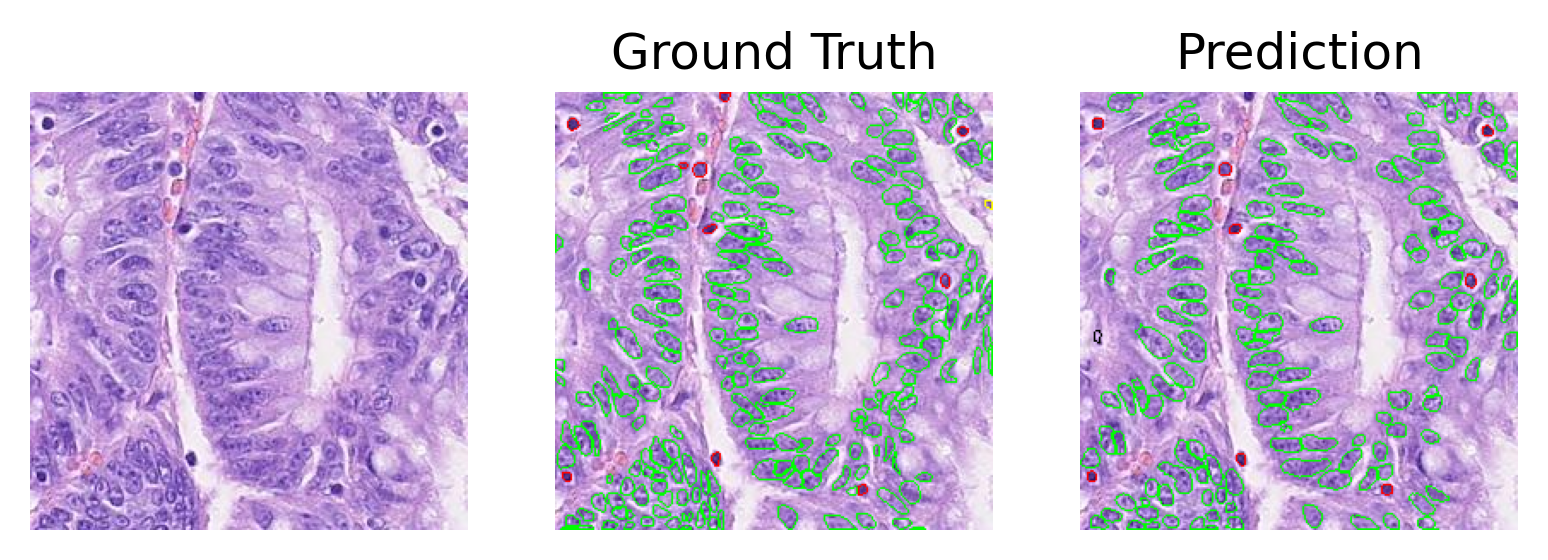

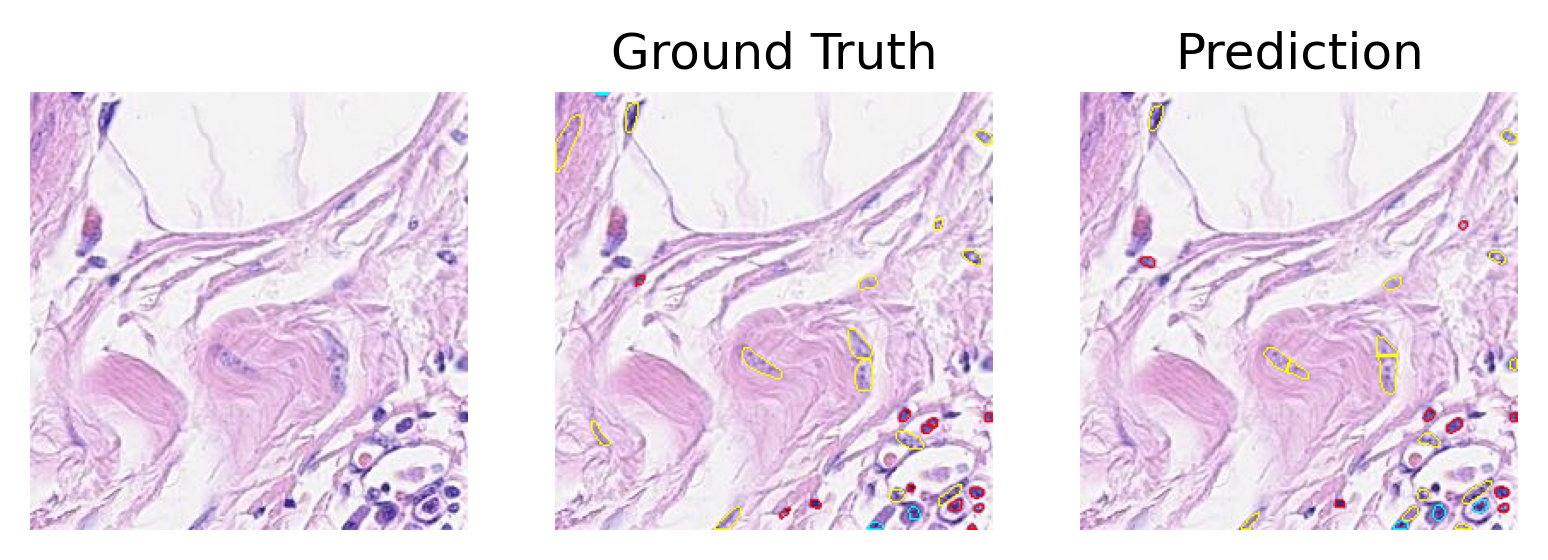

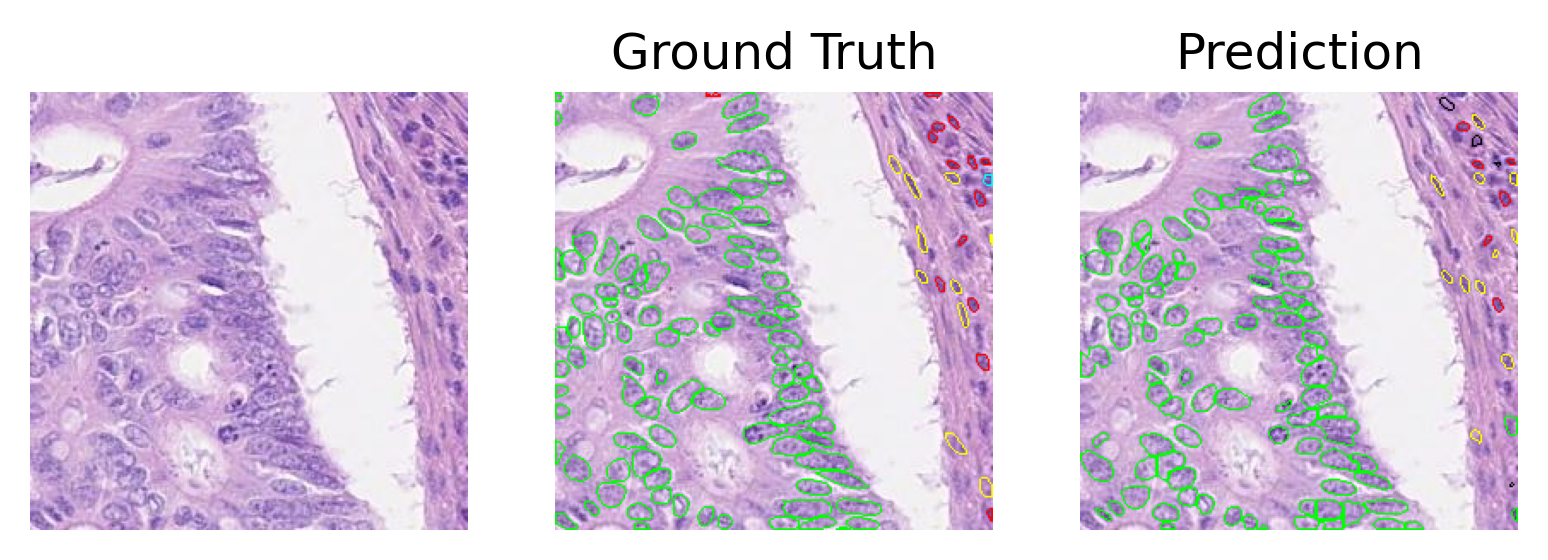

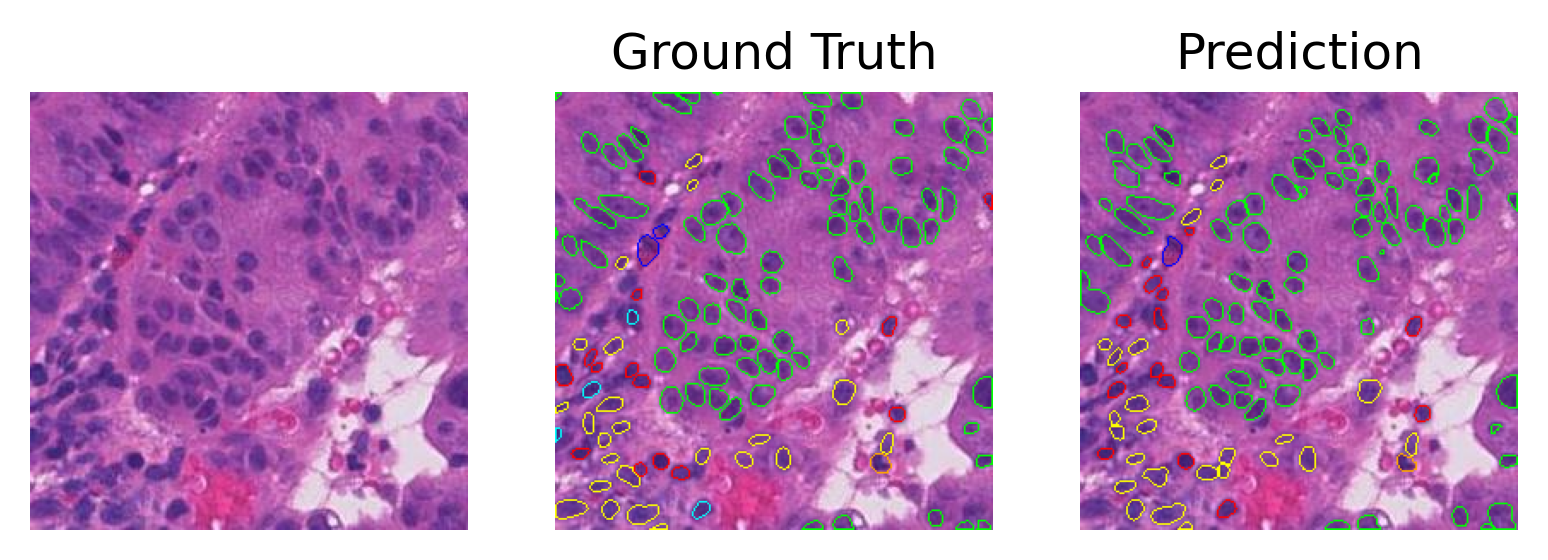

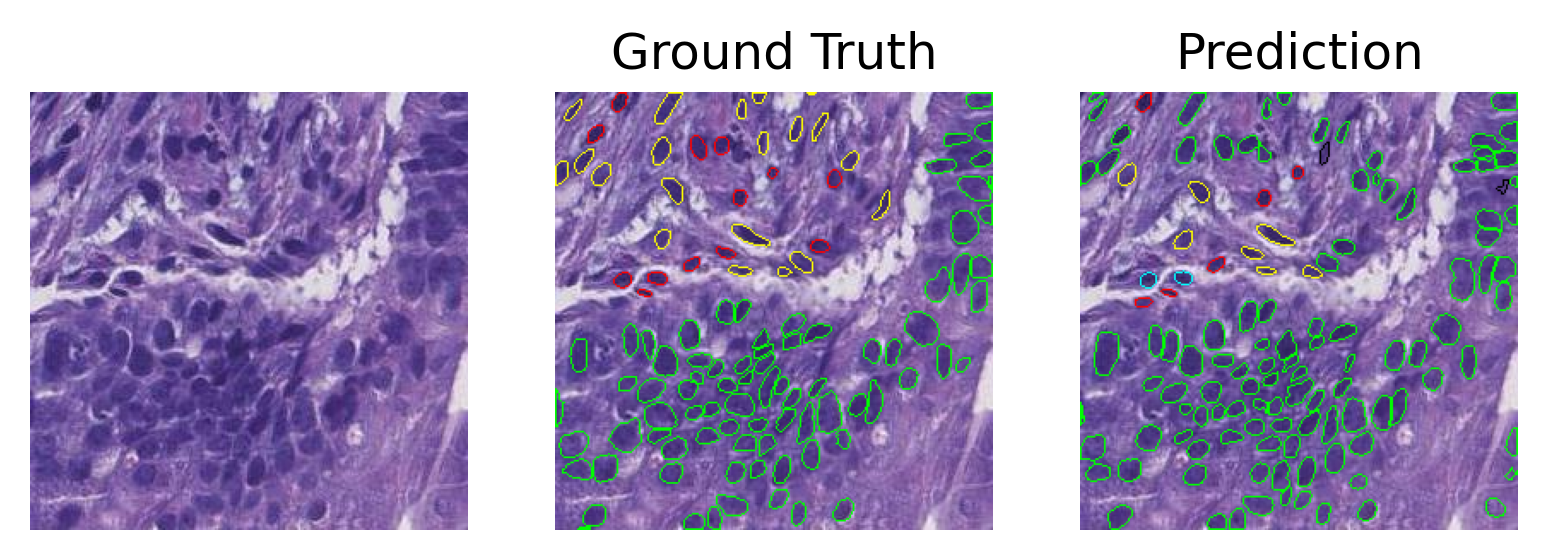

In [ ]:
from tiatoolbox.models.architecture.hovernet import HoVerNet

semantic_true = np.load(f'{OUT_DIR}/valid_true.npy')
semantic_pred = np.load(f'{OUT_DIR}/valid_pred.npy')

output_file = f'{OUT_DIR}/raw/file_map.dat'
output_info = joblib.load(output_file)

np.random.seed(SEED)
# selected_indices = np.random.choice(1608, 10)
selected_indices = np.array([4,13,210,739,1000])
# selected_indices = np.array([56])
PERCEPTIVE_COLORS = [
    (  0,   0,   0),
    (255, 165,   0),
    (  0, 255,   0),
    (255,   0,   0),
    (  0, 255, 255),
    (  0,   0, 255),
    (255, 255,   0),
]

for idx in selected_indices:
    img = cv2.imread(output_info[idx][0])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    inst_map = semantic_pred[idx][..., 0]
    type_map = semantic_pred[idx][..., 1]
    pred_inst_dict = HoVerNet.get_instance_info(inst_map, type_map)

    inst_map = semantic_true[idx][..., 0]
    type_map = semantic_true[idx][..., 1]
    true_inst_dict = HoVerNet.get_instance_info(inst_map, type_map)

    inst_type_colours = np.array([
        PERCEPTIVE_COLORS[v['type']]
        for v in true_inst_dict.values()
    ])
    overlaid_true = overlay_prediction_contours(
        img, true_inst_dict,
        inst_colours=inst_type_colours,
        line_thickness=1
    )

    inst_type_colours = np.array([
        PERCEPTIVE_COLORS[v['type']]
        for v in pred_inst_dict.values()
    ])
    overlaid_pred = overlay_prediction_contours(
        img, pred_inst_dict,
        inst_colours=inst_type_colours,
        line_thickness=1
    )

    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.imshow(overlaid_true)
    plt.title('Ground Truth')
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.imshow(overlaid_pred)
    plt.title('Prediction')
    plt.axis('off')
    plt.show()

In [ ]:
"""compute_stats.py. Calculates the statistical measurements for the CoNIC Challenge"""
import numpy as np
import os
import pandas as pd
from tqdm.auto import tqdm

from stats_utils import get_pq, get_multi_pq_info

seg_metrics_names = ["pq", "multi_pq+"]
pred_path = '/content/drive/MyDrive/hovernet/fake/valid_pred.npy'
true_path = '/content/drive/MyDrive/hovernet/fake/valid_true.npy'
all_metrics = {}

# initialise empty placeholder lists
pq_list = []
dice_list = []
mpq_info_list = []

# load the prediction and ground truth arrays
pred_array = np.load(pred_path)
true_array = np.load(true_path)
nr_patches = pred_array.shape[0]

for patch_idx in tqdm(range(nr_patches)):
  # get a single patch
  pred = pred_array[patch_idx]
  true = true_array[patch_idx]

  # instance segmentation map
  pred_inst = pred[..., 0]
  true_inst = true[..., 0]
  # classification map
  pred_class = pred[..., 1]
  true_class = true[..., 1]

  for idx, metric in enumerate(seg_metrics_names):
    if metric == "pq":
      # get binary panoptic quality
      pq = get_pq(true_inst, pred_inst)
      pq = pq[0][2]
      dice = get_pq(true_inst, pred_inst)
      dice = dice[0][0]
      pq_list.append(pq)
      dice_list.append(dice)
    elif metric == "multi_pq+":
      # get the multiclass pq stats info from single image
      mpq_info_single = get_multi_pq_info(true, pred)
      mpq_info = []
      # aggregate the stat info per class
      for single_class_pq in mpq_info_single:
        tp = single_class_pq[0]
        fp = single_class_pq[1]
        fn = single_class_pq[2]
        sum_iou = single_class_pq[3]
        mpq_info.append([tp, fp, fn, sum_iou])
        mpq_info_list.append(mpq_info)
         

pq_metrics = np.array(pq_list)
pq_metrics_avg = np.mean(pq_metrics, axis=-1)  # average over all images

dice_metrics = np.array(dice_list)
dice_metrics_avg = np.mean(dice_metrics, axis =-1)
if "multi_pq+" in seg_metrics_names:
  mpq_info_metrics = np.array(mpq_info_list, dtype="float")
  # sum over all the images
  total_mpq_info_metrics = np.sum(mpq_info_metrics, axis=0)
  for idx, metric in enumerate(seg_metrics_names):
    if metric == "multi_pq+":
      mpq_list = []
      # for each class, get the multiclass PQ
      for cat_idx in range(total_mpq_info_metrics.shape[0]):
        total_tp = total_mpq_info_metrics[cat_idx][0]
        total_fp = total_mpq_info_metrics[cat_idx][1]
        total_fn = total_mpq_info_metrics[cat_idx][2]
        total_sum_iou = total_mpq_info_metrics[cat_idx][3]

        # get the F1-score i.e DQ
        dq = total_tp / ((total_tp + 0.5 * total_fp + 0.5 * total_fn) + 1.0e-6)
        # get the SQ, when not paired, it has 0 IoU so does not impact
        sq = total_sum_iou / (total_tp + 1.0e-6)
        mpq_list.append(dq * sq)
        mpq_metrics = np.array(mpq_list)
        all_metrics[metric] = [np.mean(mpq_metrics)]
    else:
      all_metrics[metric] = [pq_metrics_avg]
all_metrics["dice"] = [dice_metrics_avg]
df = pd.DataFrame(all_metrics)
df = df.to_string(index=False)
print(df)


  0%|          | 0/1608 [00:00<?, ?it/s]

      pq  multi_pq+     dice
0.470884   0.308345 0.604432


In [ ]:
print(mpq_metrics)

[0.08894583 0.4674931  0.54558875 0.39895871 0.00186594 0.34721933]


In [ ]:
pred_path = '/content/drive/MyDrive/hovernet/real/valid_pred.npy'
true_path = '/content/drive/MyDrive/hovernet/real/valid_true.npy'
all_metrics = {}

# initialise empty placeholder lists
pq_list = []
dice_list = []
mpq_info_list = []

# load the prediction and ground truth arrays
pred_array = np.load(pred_path)
true_array = np.load(true_path)
nr_patches = pred_array.shape[0]

for patch_idx in tqdm(range(nr_patches)):
  # get a single patch
  pred = pred_array[patch_idx]
  true = true_array[patch_idx]

  # instance segmentation map
  pred_inst = pred[..., 0]
  true_inst = true[..., 0]
  # classification map
  pred_class = pred[..., 1]
  true_class = true[..., 1]

  for idx, metric in enumerate(seg_metrics_names):
    if metric == "pq":
      # get binary panoptic quality
      pq = get_pq(true_inst, pred_inst)
      pq = pq[0][2]
      dice = get_pq(true_inst, pred_inst)
      dice = dice[0][0]
      pq_list.append(pq)
      dice_list.append(dice)
    elif metric == "multi_pq+":
      # get the multiclass pq stats info from single image
      mpq_info_single = get_multi_pq_info(true, pred)
      mpq_info = []
      # aggregate the stat info per class
      for single_class_pq in mpq_info_single:
        tp = single_class_pq[0]
        fp = single_class_pq[1]
        fn = single_class_pq[2]
        sum_iou = single_class_pq[3]
        mpq_info.append([tp, fp, fn, sum_iou])
        mpq_info_list.append(mpq_info)
         

pq_metrics = np.array(pq_list)
pq_metrics_avg = np.mean(pq_metrics, axis=-1)  # average over all images

dice_metrics = np.array(dice_list)
dice_metrics_avg = np.mean(dice_metrics, axis =-1)
if "multi_pq+" in seg_metrics_names:
  mpq_info_metrics = np.array(mpq_info_list, dtype="float")
  # sum over all the images
  total_mpq_info_metrics = np.sum(mpq_info_metrics, axis=0)
  for idx, metric in enumerate(seg_metrics_names):
    if metric == "multi_pq+":
      mpq_list = []
      # for each class, get the multiclass PQ
      for cat_idx in range(total_mpq_info_metrics.shape[0]):
        total_tp = total_mpq_info_metrics[cat_idx][0]
        total_fp = total_mpq_info_metrics[cat_idx][1]
        total_fn = total_mpq_info_metrics[cat_idx][2]
        total_sum_iou = total_mpq_info_metrics[cat_idx][3]

        # get the F1-score i.e DQ
        dq = total_tp / ((total_tp + 0.5 * total_fp + 0.5 * total_fn) + 1.0e-6)
        # get the SQ, when not paired, it has 0 IoU so does not impact
        sq = total_sum_iou / (total_tp + 1.0e-6)
        mpq_list.append(dq * sq)
        mpq_metrics = np.array(mpq_list)
        all_metrics[metric] = [np.mean(mpq_metrics)]
    else:
      all_metrics[metric] = [pq_metrics_avg]
all_metrics["dice"] = [dice_metrics_avg]
df = pd.DataFrame(all_metrics)
df = df.to_string(index=False)
print(df)
print(mpq_metrics)


  0%|          | 0/1608 [00:00<?, ?it/s]

      pq  multi_pq+    dice
0.570942   0.488732 0.71092
[0.31994352 0.55083387 0.6464775  0.50791713 0.39269968 0.5145176 ]
